In [15]:
import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import os
import math
import threading
import queue
import scipy
from scipy.spatial import ConvexHull, convex_hull_plot_2d


# Import data

Field Inventory Data

In [6]:
data = os.getcwd()+"/data/"
with open(data+"field_survey.geojson") as f:
    field_survey = gpd.read_file(f)
field_survey.shape
field_survey.head()

,plot,tree_no,species,d1,d2,dbh,age,height,angle,comment,geometry
0,1.0,1.0,Birch,47.2,46.2,46.70,NaN,26.5,0.0,None,POINT (547075.84 6450425.243)
1,1.0,2.0,Aspen,27.9,29.1,28.50,NaN,NaN,0.0,None,POINT (547074.299 6450419.542)
2,1.0,3.0,Fir,12.1,13.0,12.55,NaN,NaN,0.0,None,POINT (547077.454 6450419.994)
3,1.0,4.0,Aspen,23.3,23.7,23.50,69.0,27.4,0.0,None,POINT (547078.211 6450419.02)
4,1.0,5.0,Aspen,23.2,31.3,27.25,NaN,NaN,0.0,None,POINT (547074.669 6450415.573)


In [3]:
height_described = field_survey["height"].dropna().describe()
min_height = height_described["min"]
max_height = height_described["max"]

print(max_height)

34.2


Lidar data

In [18]:
def load_lidar():
    for i in range(1,11):
        temp = laspy.read(data+"/als/plot_"+ "0"*(2-len(str(i))) + str(i) + ".las").xyz
        tempdf = pd.DataFrame(temp)
        tempdf = tempdf.rename(columns={0: "x", 1: "y", 2: "z"})
        tempdf = (tempdf-tempdf.min())/(tempdf.max()-tempdf.min())      #linear normalisation to [0,1] of all coordinates
        tempdf["plot"] = i
        if i == 1:
            lidardf = tempdf.copy()
        else:
            lidardf = pd.concat([lidardf,tempdf],ignore_index= True).copy()
        del tempdf
    return(lidardf)

lidardf = load_lidar()
lidardf.size

10956728

Take a look at our point clouds

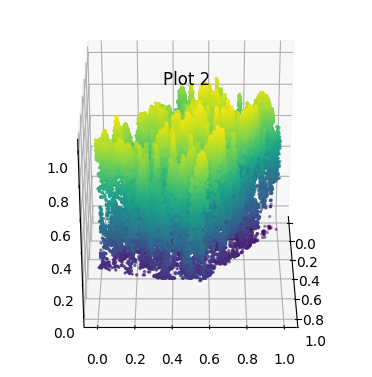

In [19]:
def plot_3d_cloud(df,i):
    #plot1 = laspy.read(data+"/als/plot_"+ "0"*(2-len(str(i))) + str(i) + ".las").xyz
    plot = df.loc[df["plot"] == i]
    plot = plot.drop(columns=['plot']).to_numpy()
    plot -= plot.min(axis=0, keepdims=True)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1, projection="3d")

    ax.scatter(
        *plot.swapaxes(0, 1),
        c=plot[:, 2],
        s=2,
    )

    ax.view_init(elev=30, azim=0)

    ax.set_title("Plot " + str (i), y=0.83)

    ax.set_aspect("equal")

plot_3d_cloud(lidardf,2)

# Filtering

In [20]:
def num_neigh(df,r):
    KDT = scipy.spatial.KDTree(np.asarray(df.drop(columns=['plot'])))        #compute KDTree for later
    arr = df.drop(columns=['plot']).to_numpy()                               #create array of (x,y,z) for iteration
    return([KDT.query_ball_point(point,r,workers = -1,return_length = True) for point in arr])

def dist_filter(df,r,a):
    iter = 0
    for i in df["plot"].unique():
        df_i = df.loc[df["plot"] == i].copy()                  #extract selected plot
        df_i["num_neigh"] = num_neigh(df_i,r)
        min_neigh = df_i.quantile(a)["num_neigh"]              #get quantile for number of neighbours
        df_i = df_i.loc[df_i["num_neigh"] >= min_neigh].drop(columns =["num_neigh"])
        if iter == 0:
            res = df_i
            iter += 1
        else:
            res = pd.concat([res,df_i],ignore_index= True)
    return(res)

def load_and_filter(a1,a2,r1,r2):
    """ a1 = specifies which quantile to use to filter out lower points
        a2 = specifies which quantile to use to filter out points with few neighbours
        r1 = radius to check for neighbours for first filtering
        r2 = radius to check for neighbours for second filtering
        
        Returns dataframe where lower a1 quantile of points are filtered out (plot per plot), and
        applies two succesive radius based filters (plot per plot)"""

    df = load_lidar()

    #Filter out lower a quantile, where the quantiles are computed plot per plot
    #Otherwise, if the ground level is not the same for each plot we remove
    #inequally between the different plots

    for i in df["plot"].unique():
        zQ = df.loc[df["plot"] == i].quantile(a1)["z"]               #compute height quantile of plot
        df = df.loc[-((df["z"] < zQ) & (df["plot"] == i))]      #remove low points from selected plot

    #--------------

    #Distance based filtering using KDTrees

    df = dist_filter(dist_filter(df,r1,a2),r2,a2)               #apply two filters successively, one rougher one finer

    #--------------

    return(df)

lidardf = load_and_filter(a1 = 0.2, a2 = 0.1,r1 = 0.1,r2 =0.01)

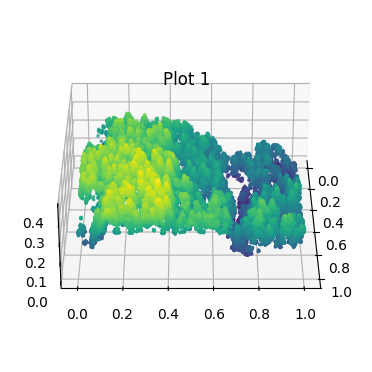

In [22]:
plot_3d_cloud(lidardf,1)